In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
#from IPython.display import Video

## The Runge-Kutta Algorithm

First of all, we copied the functions given on moodle for the basic 4-step Runge-Kutta Algorithm

In [2]:
def rk4_step(y0, x0, f, h, f_args = {}):
    ''' Simple python implementation for one RK4 step. 
        Inputs:
            y_0    - M x 1 numpy array specifying all variables of the ODE at the current time step
            x_0    - current time step
            f      - function that calculates the derivates of all variables of the ODE
            h      - time step size
            f_args - Dictionary of additional arguments to be passed to the function f
        Output:
            yp1 - M x 1 numpy array of variables at time step x0 + h
            xp1 - time step x0+h
    '''
    k1 = h * f(y0, x0, **f_args)
    k2 = h * f(y0 + k1/2., x0 + h/2., **f_args)
    k3 = h * f(y0 + k2/2., x0 + h/2., **f_args)
    k4 = h * f(y0 + k3, x0 + h, **f_args)
    
    xp1 = x0 + h
    yp1 = y0 + 1./6.*(k1 + 2.*k2 + 2.*k3 + k4)
    
    return(yp1,xp1)

def rk4(y0, x0, f, h, n, f_args = {}):
    ''' Simple implementation of RK4
        Inputs:
            y_0    - M x 1 numpy array specifying all variables of the ODE at the current time step
            x_0    - current time step
            f      - function that calculates the derivates of all variables of the ODE
            h      - time step size
            n      - number of steps
            f_args - Dictionary of additional arguments to be passed to the function f
        Output:
            yn - N+1 x M numpy array with the results of the integration for every time step (includes y0)
            xn - N+1 x 1 numpy array with the time step value (includes start x0)
    '''
    yn = np.zeros((n+1, y0.shape[0]))
    xn = np.zeros(n+1)
    yn[0,:] = y0
    xn[0] = x0
    
    for n in np.arange(1,n+1,1):
        yn[n,:], xn[n] = rk4_step(y0 = yn[n-1,:], x0 = xn[n-1], f = f, h = h, f_args = f_args)
        
    return(yn, xn)

# Be advised that the integration can take a while for large values of n (e.g >=10^5).

Then we addded the missing functions to calculate the 3body problem, the second order differentail equation is turned into a larger set of 1st order differential equations  
  
For the three body problem we get the following equation  
  
$\ddot{\vec{r_{1}}} = Gm_{2}\frac{\vec{r_{2}}-\vec{r_{1}}}{|\vec{r_{1}}-\vec{r_{2}}|^{3}}+Gm_{3}\frac{\vec{r_{3}}-\vec{r_{1}}}{|\vec{r_{1}}-\vec{r_{3}}|^{3}} $  
  
(analogue for all permutations)  

This is a ODE of second order, thus we need to turn it into a pair of first order ODE's to be able to work with it. We introduce a new set of equations: 

\begin{equation*}
u_{1} = x_1 \\
u_2 = y_1 \\
u_{3} = \dot{x}_1 \\
u_{4} = \dot{y}_1 \\
u_{5} = x_2 \\
u_6 = y_2 \\
u_{7} = \dot{x}_2 \\
u_{8} = \dot{y}_2 \\
u_{9} = x_3 \\
u_{10} = y_3 \\
u_{11} = \dot{x}_3 \\
u_{12} = \dot{y}_3 \\
\end{equation*}

Using the new variables we can formulate the $1{st}$ order ODE's ($r_{ij}=|\vec{r_{i}}-\vec{r_{j}}| $)
 
\begin{equation*}
\dot{u_{1}} = u_3 \\
\dot{u_{2}} = u_4 \\
u_{3} = Gm_{2}\frac{u_{5}-u_{1}}{r_{12}^{3}}+Gm_{3}\frac{u_{9}-u_{1}}{r_{13}^{3}} \\
u_{4} = Gm_{2}\frac{u_{6}-u_{2}}{r_{12}^{3}}+Gm_{3}\frac{u_{10}-u_{2}}{r_{13}^{3}} \\
\dot{u_{5}} = u_7 \\
\dot{u_{6}} = u_8 \\
u_{7} = Gm_{1}\frac{u_{1}-u_{5}}{r_{12}^{3}}+Gm_{3}\frac{u_{9}-u_{5}}{r_{23}^{3}} \\
u_{8} = Gm_{1}\frac{u_{2}-u_{6}}{r_{12}^{3}}+Gm_{3}\frac{u_{10}-u_{6}}{r_{23}^{3}} \\
\dot{u_{9}} = u_11 \\
\dot{u_{10}} = u12 \\
u_{11} = Gm_{1}\frac{u_{1}-u_{9}}{r_{13}^{3}}+Gm_{2}\frac{u_{5}-u_{9}}{r_{23}^{3}} \\
u_{12} = Gm_{1}\frac{u_{2}-u_{10}}{r_{13}^{3}}+Gm_{2}\frac{u_{6}-u_{10}}{r_{23}^{3}} \\
\end{equation*}

Now we implement these ODE's into our Runge-Kutta Method.

In [3]:
#Functions for Coordinates of the 1st body
def f_1x(x1, x2, x3, y1, y2, y3):
    return G*m2*(x2-x1)/(np.sqrt((x2-x1)**2+(y2-y1)**2))**3 + G*m3*(x3-x1)/(np.sqrt((x3-x1)**2+(y3-y1)**2))**3 
def f_1y(x1, x2, x3, y1, y2, y3):
    return G*m2*(y2-y1)/(np.sqrt((x2-x1)**2+(y2-y1)**2))**3 + G*m3*(y3-y1)/(np.sqrt((x3-x1)**2+(y3-y1)**2))**3 

#Functions for Coordinates of the 2nd body
def f_2x(x1, x2, x3, y1, y2, y3):
    return G*m1*(x1-x2)/(np.sqrt((x1-x2)**2+(y1-y2)**2))**3  + G*m3*(x3-x2)/(np.sqrt((x3-x2)**2+(y3-y2)**2))**3 
def f_2y(x1, x2, x3, y1, y2, y3):
    return G*m1*(y1-y2)/(np.sqrt((x1-x2)**2+(y1-y2)**2))**3  + G*m3*(y3-y2)/(np.sqrt((x3-x2)**2+(y3-y2)**2))**3 

#Functions for Coordinates of the 3rd body
def f_3x(x1, x2, x3, y1, y2, y3):
    return G*m2*(x2-x3)/(np.sqrt((x2-x3)**2+(y2-y3)**2))**3  + G*m1*(x1-x3)/(np.sqrt((x1-x3)**2+(y1-y3)**2))**3 
def f_3y(x1, x2, x3, y1, y2, y3):
    return G*m2*(y2-y3)/(np.sqrt((x2-x3)**2+(y2-y3)**2))**3  + G*m1*(y1-y3)/(np.sqrt((x1-x3)**2+(y1-y3)**2))**3 


#Function for the Runge-Kutta calculation
#Calculates the acceleration and shifts the velocity to the position index in the pos_vel array
def f_1(pos_vel, x0):
    a_x1 = f_1x(pos_vel[0], pos_vel[2], pos_vel[4], pos_vel[6], pos_vel[8], pos_vel[10])
    a_x2 = f_2x(pos_vel[0], pos_vel[2], pos_vel[4], pos_vel[6], pos_vel[8], pos_vel[10])
    a_x3 = f_3x(pos_vel[0], pos_vel[2], pos_vel[4], pos_vel[6], pos_vel[8], pos_vel[10])
    a_y1 = f_1y(pos_vel[0], pos_vel[2], pos_vel[4], pos_vel[6], pos_vel[8], pos_vel[10])
    a_y2 = f_2y(pos_vel[0], pos_vel[2], pos_vel[4], pos_vel[6], pos_vel[8], pos_vel[10])
    a_y3 = f_3y(pos_vel[0], pos_vel[2], pos_vel[4], pos_vel[6], pos_vel[8], pos_vel[10])
    vel_acc_step = np.array([pos_vel[1], a_x1, pos_vel[3], a_x2, pos_vel[5], a_x3, pos_vel[7], a_y1,pos_vel[9], a_y2,pos_vel[11], a_y3])
    return vel_acc_step



In the next step we integrate the trajectories of all three bodies and save the positions as well as the velocities of all times.

In [4]:
#function integrates the trajectories of the three bodies from starting time xo till end time x_max,
#by calling upon the previously discussed functions.
#returns array x and y positions and velocities of all three bodies for every timestep in lists
#the argument pos_vel defines the starting conditions: [x1,vx1,x2,vx2,x3,vx3,y1,vy1,y2,vy2,y3,vy3]
def calc(x_max, x0, pos_vel, h):
    """
    This func
    """
    POS_VEL = []
    X0 = []
    while x0 < x_max:
        POS_VEL.append(pos_vel)
        X0.append(x0)
        pos_vel, x0 = rk4_step(np.array(pos_vel), x0, f_1, h)
   
    return POS_VEL, X0

#Turns pos_vel array into 1D arrays for individual x and y coordinates
#This function takes the from the clac function created array
def turn_pos_vel_into_1D_arrays(pos_vel):
    x1list = []
    x2list = [] 
    x3list = [] 
    y1list = [] 
    y2list = []
    y3list = [] 
    vx1list = []
    vx2list = [] 
    vx3list = [] 
    vy1list = [] 
    vy2list = []
    vy3list = [] 
    for i in pos_vel:
        x1list.append(i[0])
        x2list.append(i[2])
        x3list.append(i[4])
        y1list.append(i[6])
        y2list.append(i[8])
        y3list.append(i[10])
        vx1list.append(i[1])
        vx2list.append(i[3])
        vx3list.append(i[5])
        vy1list.append(i[7])
        vy2list.append(i[9])
        vy3list.append(i[11])
    return x1list, y1list, x2list, y2list, x3list, y3list, vx1list, vy1list, vx2list, vy2list, vx3list, vy3list

   

## Part A
First, the trajectories of the three bodies are calculated, using the masses and starting positions and velocities as specified in the homeworksheet. 

In [5]:
#Start and end of calculation
x0 = 0
x_max = 6.4

#Stepsize
h = 0.01
#Masses of bodies
m1 = 1
m2 = 1
m3 = 1
#Gravitational constant
G = 1

#Starting positions and velocities
x1,  y1 = -0.97000436,  0.24308753
vx1, vy1 = -0.46620368, -0.43236573

x2,  y2 =  0.97000436, -0.24308753
vx2, vy2 = -0.46620368, -0.43236573

x3,  y3 = 0.0,        0.0
vx3, vy3 = 0.93240737, 0.86473146


#One array to combine all positions and velocities of the three bodies
pos_vel=np.array([x1,vx1,x2,vx2,x3,vx3,y1,vy1,y2,vy2,y3,vy3])


#calculate
POS_VEL, X0 = calc(x_max, x0, pos_vel, h)
x1list, y1list, x2list, y2list, x3list, y3list, vx1list, vy1list, vx2list, vy2list, vx3list, vy3list = turn_pos_vel_into_1D_arrays(POS_VEL)


Then the trajectories of each of the three masses are plotted on their own, as well as in the same diagram(plot 4).  
  
While looking at the trajectories of the three bodies plotted seperately, notice the color code. While the form of the trajectories is the same for all objects, the position at a given time is different.

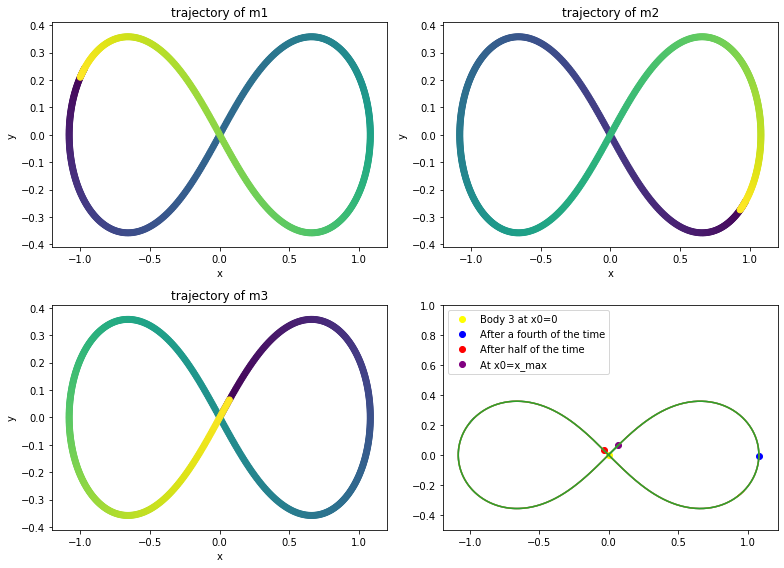

In [7]:
#plot
fig = plt.figure(figsize=(11,8))

#Plot body 1
ax1=plt.subplot(2,2,1)
ax1.set_title("trajectory of m1")
ax1.set_ylabel("y")
ax1.set_xlabel("x")
ax1.scatter(x1list, y1list, c=X0)

#PLot body 2
ax2=plt.subplot(2,2,2)
ax2.set_title("trajectory of m2")
ax2.set_ylabel("y")
ax2.set_xlabel("x")
ax2.scatter(x2list, y2list, c=X0)

#PLot body 3
ax3=plt.subplot(2,2,3)
ax3.set_title("trajectory of m3")
ax3.set_ylabel("y")
ax3.set_xlabel("x")
ax3.scatter(x3list, y3list, c=X0)

ax4=plt.subplot(2,2,4)
ax2.set_ylabel("y")
ax2.set_xlabel("x")
ax4.plot(x1list, y1list)
ax4.plot(x2list, y2list)
ax4.plot(x3list, y3list)
ax4.set_ylim(-0.5, 1)
ax4.scatter(x3, y3, c="yellow", label="Body 3 at x0=0")
ax4.scatter(x3list[int(len(x3list)/4)], y3list[int(len(x1list)/4)], c="blue", label="After a fourth of the time")
ax4.scatter(x3list[int(len(x3list)/2)], y3list[int(len(x3list)/2)], c="red", label="After half of the time")
ax4.scatter(x3list[-1], y3list[-1], c="purple", label="At x0=x_max")
ax4.legend(loc='upper left')
plt.tight_layout()

In [ ]:
Video("Anim_a.mp4")

We can see that these initial values create a stable and not chaotic result. All bodies are moving in an $\infty$ shape.


## Part B
Now we want to take a closer look at the effect of the stepsize on the calculations. For this, we first calculate the trajectories using four different Stepsizes h , ranging from 0.1 to 0.0001.  
The starting coordinates of the masses were derived from the instructions on the homeworksheet using simple trigonometry.  
For every value of h all of the positions and velocities are calculated and saved.  
(In the following parts the prefix A will always correspond to h = 0.1, B to h = 0.01 etc.)

In [7]:
#Start and end of calculation
x0 = 0
x_max = 5


#Masses of bodies
m1 = 3.
m2 = 4.
m3 = 5.
#Gravitational constant
G = 1

#Starting positions and velocities
x1,  y1  =  4.0, -3.0
vx1, vy1 =  0.0,  0.0

x2,  y2  =  0.0,   0.0
vx2, vy2 =  0.0,   0.0

x3,  y3  =  0.0,  -3.0
vx3, vy3 =  0.0,   0.0


#One array to combine all positions and velocities of the three bodies
pos_vel=np.array([x1,vx1,x2,vx2,x3,vx3,y1,vy1,y2,vy2,y3,vy3])

#Calculate for different timesteps
M = m1+m2+m3
h=0.1
A_POS_VEL, A_x0 = calc(x_max, x0, pos_vel, h)
Ax1list, Ay1list, Ax2list, Ay2list, Ax3list, Ay3list , Avx1list, Avy1list, Avx2list, Avy2list, Avx3list, Avy3list = turn_pos_vel_into_1D_arrays(A_POS_VEL)


h=0.01
B_POS_VEL, B_X0 = calc(x_max, x0, pos_vel, h)
Bx1list, By1list, Bx2list, By2list, Bx3list, By3list, Bvx1list, Bvy1list, Bvx2list, Bvy2list, Bvx3list, Bvy3list = turn_pos_vel_into_1D_arrays(B_POS_VEL)


h=0.001
C_POS_VEL, C_X0 = calc(x_max, x0, pos_vel, h)
Cx1list, Cy1list, Cx2list, Cy2list, Cx3list, Cy3list, Cvx1list, Cvy1list, Cvx2list, Cvy2list, Cvx3list, Cvy3list = turn_pos_vel_into_1D_arrays(C_POS_VEL)

h=0.0001
D_POS_VEL, D_X0 = calc(x_max, x0, pos_vel, h)
Dx1list, Dy1list, Dx2list, Dy2list, Dx3list, Dy3list, Dvx1list, Dvy1list, Dvx2list, Dvy2list, Dvx3list, Dvy3list = turn_pos_vel_into_1D_arrays(D_POS_VEL)



After calculating the positions we will draw the trajectories of the three bodies.  
  
To simplify the process we implemented the function "draw_trajectories". (For the next plots a similar function is implemented for each plot).  
This is done because every plot gets the same kind of input (same axes, the same things are plotted...) but with different values.

In [8]:
def draw_trajectories(ax,Ax1list, Ay1list, Ax2list, Ay2list, Ax3list, Ay3list):
    ax.scatter(x1, y1, color="black", label="start")
    #plt.scatter(x_center_of_mass, y_center_of_mass, color="purple", label="Center of mass")
    ax.scatter(x2, y2, color="black")
    ax.scatter(x3, y3, color="black")
    ax.plot(Ax1list, Ay1list, color="blue", label="1")
    ax.plot(Ax2list, Ay2list, color="green", label="2")
    ax.plot(Ax3list, Ay3list, color="orange", label="3")
    ax.scatter(Ax1list[-1], Ay1list[-1], color="blue")
    ax.scatter(Ax2list[-1], Ay2list[-1], color="green")
    ax.scatter(Ax3list[-1], Ay3list[-1], color="orange")
    ax.legend(loc= "upper right")
    return

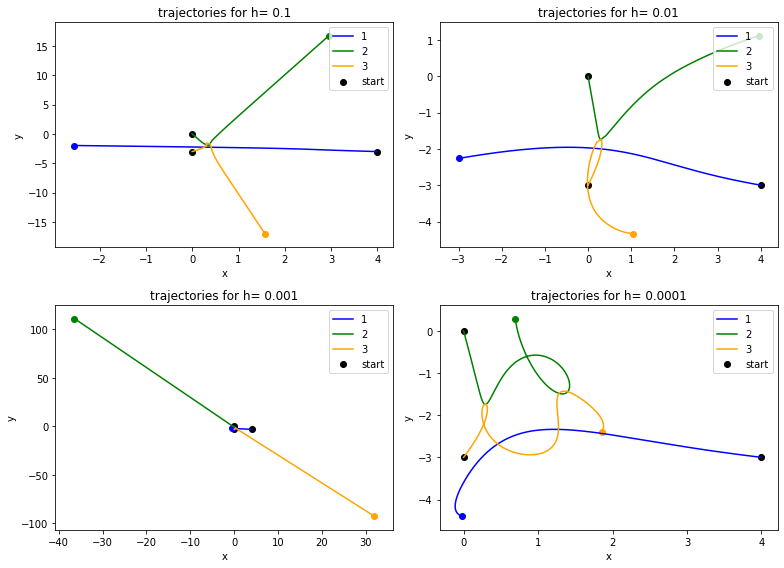

In [12]:
fig=plt.figure(figsize=(11,8),tight_layout="true")
#fig.suptitle("trajectories for different time steps h")
#Plot trajectories for h=0.1
ax1=plt.subplot(2,2,1)
ax1.set_title("trajectories for h= 0.1")
ax1.set_ylabel("y")
ax1.set_xlabel("x")
draw_trajectories(ax1,Ax1list, Ay1list, Ax2list, Ay2list, Ax3list, Ay3list)


#Plot for h=0.01
ax2=plt.subplot(2,2,2)
ax2.set_title("trajectories for h= 0.01")
ax2.set_ylabel("y")
ax2.set_xlabel("x")
draw_trajectories(ax2,Bx1list, By1list, Bx2list, By2list, Bx3list, By3list)


#Plot for h=0.001
ax3=plt.subplot(2,2,3)

ax3.set_title("trajectories for h= 0.001")
ax3.set_ylabel("y")
ax3.set_xlabel("x")
draw_trajectories(ax3,Cx1list, Cy1list, Cx2list, Cy2list, Cx3list, Cy3list)

#Plot for h=0.0001
ax4=plt.subplot(2,2,4)
ax4.set_title("trajectories for h= 0.0001")
ax4.set_ylabel("y")
ax4.set_xlabel("x")
draw_trajectories(ax4,Dx1list, Dy1list, Dx2list, Dy2list, Dx3list, Dy3list)

As we can see the trajectories are very different for different h.  
So it makes sense to quantify the error as good as possible. To do so we will look at the behaviour of the total energy as well as the mutual distances.

In the following animation, one can see the trajectories of all three bodies. The purple dot is the center of mass.

In [ ]:
Video("Plot_b.mp4")

Now we take a look at the mutual distances between two masses. So we get the distance between m1 and m2, m2 and m3 as well as m1 and m3.  
This distances will be calculated, saved for every time (in a given intervall) and then plotted.

In [13]:
#function calcuates distance between two masses at one point in time and returns that value
def dist(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

#function calculates distance between all masspoints over time and returns three lists containing
#all the distances
def calc_distances(x1list,y1list,x2list,y2list,x3list,y3list):
    dist12=[]
    dist23=[]
    dist13=[]
    for i in range(0,len(x1list),1):
        dist12.append(dist(x1list[i],y1list[i],x2list[i],y2list[i]))
        dist13.append(dist(x1list[i],y1list[i],x3list[i],y3list[i]))
        dist23.append(dist(x2list[i],y2list[i],x3list[i],y3list[i]))
    return dist12,dist23,dist13


def draw_distances(ax,h,t,dist12,dist23,dist13):
    ax.set_title("distances of masses for h=%.4f"%(h))
    ax.set_xlabel("time t ")
    ax.set_ylabel("distance")
    ax.set_yscale("log")
    #ax.set_xscale("log")
    ax.plot(t,dist12,label="distance m1,m2")
    ax.plot(t,dist23,label="distance m2,m3")
    ax.plot(t,dist13,label="distance m1,m3")
    ax.legend(loc="upper left")
    return

In [14]:
tA=np.linspace(0,x_max,round(x_max/0.1)+1)
tB=np.linspace(0,x_max,round(x_max/0.01)+1)
tC=np.linspace(0,x_max,round(x_max/0.001))
tD=np.linspace(0,x_max,round(x_max/0.0001))

#calculate
Adist12,Adist23,Adist13=calc_distances(Ax1list,Ay1list,Ax2list,Ay2list,Ax3list,Ay3list)
Bdist12,Bdist23,Bdist13=calc_distances(Bx1list,By1list,Bx2list,By2list,Bx3list,By3list)
Cdist12,Cdist23,Cdist13=calc_distances(Cx1list,Cy1list,Cx2list,Cy2list,Cx3list,Cy3list)
Ddist12,Ddist23,Ddist13=calc_distances(Dx1list,Dy1list,Dx2list,Dy2list,Dx3list,Dy3list)

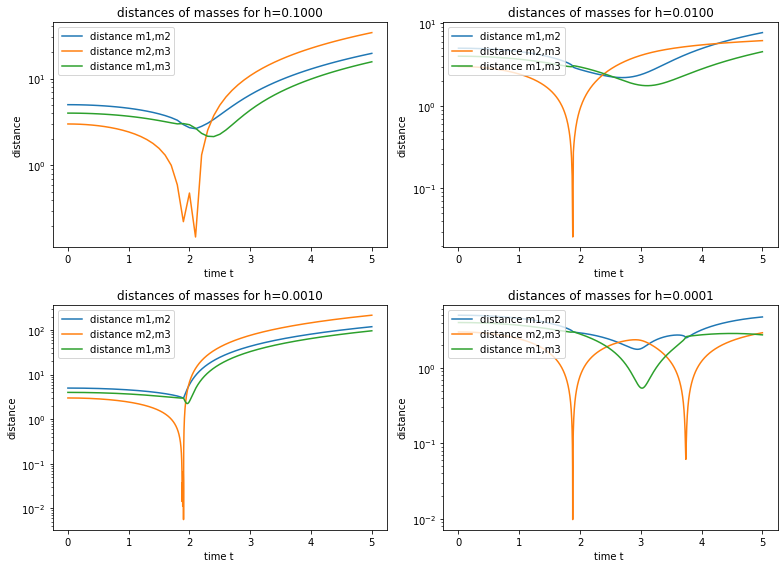

In [15]:
#Plot
fig=plt.figure(figsize=(11,8))

#Plot distance for h=0.1
ax1=plt.subplot(2,2,1)
draw_distances(ax1,0.1,tA,Adist12,Adist23,Adist13)

#PLot for h=0.01
ax2=plt.subplot(2,2,2)
draw_distances(ax2,0.01,tB,Bdist12,Bdist23,Bdist13)

#PLot for h=0.001
ax3=plt.subplot(2,2,3)
draw_distances(ax3,0.001,tC,Cdist12,Cdist23,Cdist13)

#Plot for H=0.0001
ax4=plt.subplot(2,2,4)
draw_distances(ax4,0.0001,tD,Ddist12,Ddist23,Ddist13)
plt.tight_layout()

While comparing the distances it shows that the step size has a big impact.  
  
Even though at around t = 2 there is a very clear minimum for the distance of m2 and m3.
At the time around minima the interaction between two bodies is very big, so the accelaration is very high at this points as well.  
The bodies change their direction very fast and even small timesteps become too big to approximate the trajectory and distances very precisely.

Similar to the approach of plotting the mutual distances, the total energy and total energy error of the system will be plotted.  
  
Since the total energy is made up of the gravitational and kinetic energy, its easier to divide the total energy (this helps with decreasing errors while implementing due to shorter formulas).  
  
The gravitational/potential Energy is  
  
$E_{pot} = -\frac{Gm_{1}m_{2}}{|\vec{r_{1}}-\vec{r_{2}}|}-\frac{Gm_{1}m_{3}}{|\vec{r_{1}}-\vec{r_{3}}|}-\frac{Gm_{3}m_{2}}{|\vec{r_{3}}-\vec{r_{2}}|}$  
  
The kinetic Energy can be calculated via  
  
$E_{kin} = \frac{\vec{p_{1}}^{2}}{2m_{1}}+\frac{\vec{p_{2}}^{2}}{2m_{2}}+\frac{\vec{p_{3}}^{2}}{2m_{3}}$  
  
And finally  
  
$E = E_{kin} + E_{pot}$

In [16]:
#calculate the total energy (hamiltonian) of the system

#potential (gravitational) energy
def E_pot(G,m1,m2,m3,x1,y1,x2,y2,x3,y3):
    return (-G*m1*m2/dist(x1,y1,x2,y2) - G*m2*m3/dist(x2,y2,x3,y3) - G*m1*m3/(dist(x1,y1,x3,y3)))
#kinetic energy                                                                    
def E_kin(m1,m2,m3,vx1,vy1,vx2,vy2,vx3,vy3):
    return (m1**2*(vx1**2+vy1**2)/(2*m1)) + (m2**2*(vx2**2+vy2**2)/(2*m2)) + (m3**2*(vx3**2+vy3**2)/(2*m3))                                                                    

#the hamiltonian is the sum of kinetic and gravitational energy
def hamiltonian(x1list,y1list,x2list,y2list,x3list,y3list,vx1list,vy1list,vx2list,vy2list,vx3list,vy3list):
    H=[]
    for i in range(0,len(x1list),1):
        H.append(E_pot(G,m1,m2,m3,x1list[i],y1list[i],x2list[i],y2list[i],x3list[i],y3list[i])+E_kin(m1,m2,m3,vx1list[i],vy1list[i],vx2list[i],vy2list[i],vx3list[i],vy3list[i]))
    return H

Firstly we calculate the list of values of the total energy at any given time. The prefices A-D are used as above.  
  
Next up a function to draw the energies is implemented, the total energies are plotted.

In [17]:
#calculate the hamiltonian for the four different time steps
H1 = hamiltonian(Ax1list,Ay1list,Ax2list,Ay2list,Ax3list,Ay3list,Avx1list,Avy1list,Avx2list,Avy2list,Avx3list,Avy3list)
H2 = hamiltonian(Bx1list,By1list,Bx2list,By2list,Bx3list,By3list,Bvx1list,Bvy1list,Bvx2list,Bvy2list,Bvx3list,Bvy3list)
H3 = hamiltonian(Cx1list,Cy1list,Cx2list,Cy2list,Cx3list,Cy3list,Cvx1list,Cvy1list,Cvx2list,Cvy2list,Cvx3list,Cvy3list)
H4 = hamiltonian(Dx1list,Dy1list,Dx2list,Dy2list,Dx3list,Dy3list,Dvx1list,Dvy1list,Dvx2list,Dvy2list,Dvx3list,Dvy3list)

In [18]:
def draw_energies(ax,h,t,H):
    ax.set_title("energy for h=%.4f"%(h))
    ax.set_xlabel("time t ")
    ax.set_ylabel("energy")
    #ax.set_yscale("log")
    ax.plot(t,H)
    return

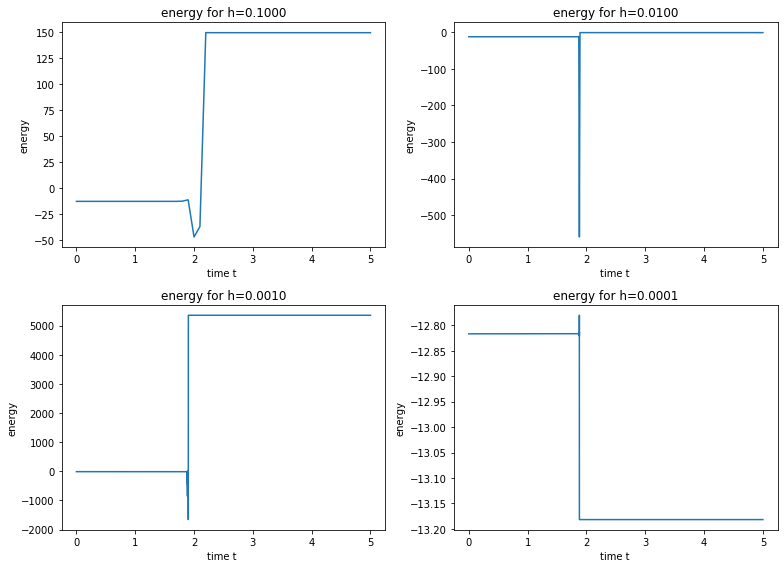

In [19]:
fig=plt.figure(figsize=(11,8))
#plot for h = 0.1
ax1=plt.subplot(2,2,1)
draw_energies(ax1,0.1,tA,H1)

#plot for h = 0.01
ax2=plt.subplot(2,2,2)
draw_energies(ax2,0.01,tB,H2)

#plot for h = 0.001
ax3=plt.subplot(2,2,3)
draw_energies(ax3,0.001,tC,H3)

#plot for h = 0.0001
ax4=plt.subplot(2,2,4)
draw_energies(ax4,0.0001,tD,H4)

plt.tight_layout()

As mentioned above, the acceleration gets too big too fast around the minima of the distances.  
Therefore we can't calculate the energy precisely enough and get this high saltus of the function.  
We'll notice an keep in mind that this occurs around t = 2 for every time step.

We're mostly interested in the total energy error rather than the energy itself. So we need another function to calculate this error.  
  
The total energy error is given with  
  
$\Delta E = |E(t)-E_{0}|$  
  
where $E_{0}$ is the energy at the starting point t = 0.  
  
After calculation, completly analogue to the plots above, we plot the energie errors for different step sizes h.

In [20]:
#calculate the energy error
def energyerror(H):
    d_E = []
    for e in H:
        de = np.abs(e-H[0])
        d_E.append(de)
    return d_E

def draw_energie_errors(ax,h,t,d_E):
    ax.set_title("energy error for h=%.4f"%(h))
    ax.set_xlabel("time t ")
    ax.set_ylabel("energy error")
    ax.set_yscale("log")
    ax.plot(t,d_E)
    return

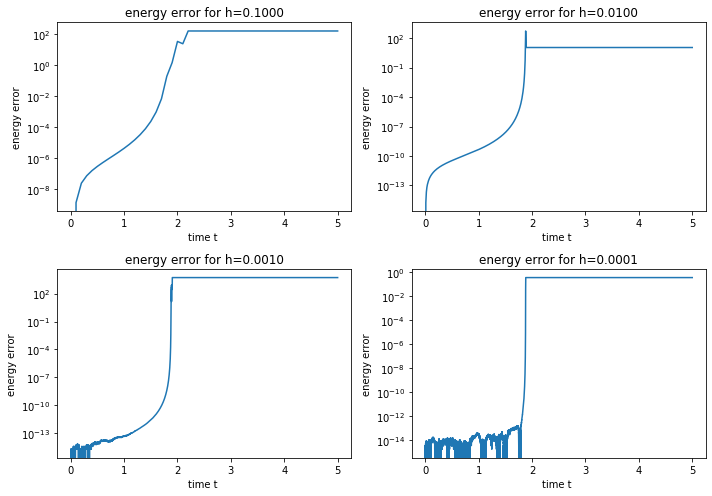

In [21]:
fig=plt.figure(figsize=(10,7))

#plot for h = 0.1
ax1=plt.subplot(2,2,1)
draw_energie_errors(ax1,0.1,tA,energyerror(H1))

#plot for h = 0.01
ax2=plt.subplot(2,2,2)
draw_energie_errors(ax2,0.01,tB,energyerror(H2))

#plot for h = 0.001
ax3=plt.subplot(2,2,3)
draw_energie_errors(ax3,0.001,tC,energyerror(H3))

#plot for h = 0.0001
ax4=plt.subplot(2,2,4)
draw_energie_errors(ax4,0.0001,tD,energyerror(H4))

plt.tight_layout()

As one might have guessed from the energy functions above, the total energy error makes a steep jump at around t = 2 as well.  
Since the energy is conserved in this system and we had a saltus of the energy function at this point this is what we would expect.  

For smaller time steps it is noticable that the jump becomes steeper and steeper till it reaches nearly a vertical slope.  
Another observation is that the energy error stays pretty much constant after this jump.